# 投球分類モデル: ハイパーパラメータ最適化 (Optuna)
**作成日**: 2026/01/13
**目的**: Optuna (ベイズ最適化) を使用して、XGBoost, LightGBM, RandomForest の各モデルのハイパーパラメータを最適化し、アンサンブル精度を向上させる。
**ベースライン**: `asao_1313` (Accuracy 92.4%, F1 92.3%)


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import lightgbm as lgbm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, f1_score
import optuna
from optuna.samplers import TPESampler
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['font.family'] = 'sans-serif'


In [3]:
# データ読み込みと特徴量エンジニアリング
df = pd.read_csv('train_with_features.csv')

# Feature Engineering (Phase 1)
df['velocity_times_pfx_z'] = df['release_speed'] * df['pfx_z']
df['spin_per_mph'] = df['release_spin_rate'] / df['release_speed']
df['horizontal_vertical_ratio'] = df['pfx_x'] / (df['pfx_z'].abs() + 0.1)
df['speed_spin_ratio'] = df['release_speed'] / (df['release_spin_rate'] + 1)

features = [
    'release_speed', 'release_spin_rate', 'spin_axis', 'pfx_x', 'pfx_z',
    'release_pos_x', 'release_pos_z', 'movement_magnitude', 
    'velocity_times_pfx_z', 'spin_per_mph', 'normalized_spin_axis',
    'speed_spin_ratio', 'horizontal_vertical_ratio',
    'spin_efficiency', 'abs_horizontal_movement', 'movement_angle'
]
target = 'pitch_type'

existing_features = [f for f in features if f in df.columns]
df_clean = df.dropna(subset=existing_features + [target]).copy()

le = LabelEncoder()
y = le.fit_transform(df_clean[target])
X = df_clean[existing_features]

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Train shape: {X_train.shape}, Valid shape: {X_valid.shape}")


Train shape: (396363, 16), Valid shape: (99091, 16)


In [4]:
# === Optuna Optimization: XGBoost ===
print("Optimizing XGBoost...")

def objective_xgb(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0.0, 0.5),
        'n_jobs': -1,
        'random_state': 42,
        'objective': 'multi:softprob'
    }
    
    model = xgb.XGBClassifier(**params)
    # 3-fold CV for robustness
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring='f1_weighted', n_jobs=-1)
    return scores.mean()

study_xgb = optuna.create_study(direction='maximize', sampler=TPESampler(seed=42))
study_xgb.optimize(objective_xgb, n_trials=50, show_progress_bar=True)

print(f"Best XGBoost F1: {study_xgb.best_value:.4f}")
print(f"Best Params: {study_xgb.best_params}")

# Train final model with best params
best_xgb = xgb.XGBClassifier(**study_xgb.best_params, n_jobs=-1, random_state=42, objective='multi:softprob')
best_xgb.fit(X_train, y_train)


[I 2026-01-13 20:10:33,330] A new study created in memory with name: no-name-3755afda-0332-435e-a980-53b8a2158911


Optimizing XGBoost...


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2026-01-13 20:10:56,856] Trial 0 finished with value: 0.8998130912504552 and parameters: {'n_estimators': 106, 'max_depth': 10, 'learning_rate': 0.1205712628744377, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746, 'min_child_weight': 2, 'gamma': 0.02904180608409973}. Best is trial 0 with value: 0.8998130912504552.
[I 2026-01-13 20:11:30,423] Trial 1 finished with value: 0.8969583127855417 and parameters: {'n_estimators': 180, 'max_depth': 7, 'learning_rate': 0.11114989443094977, 'subsample': 0.608233797718321, 'colsample_bytree': 0.9879639408647978, 'min_child_weight': 9, 'gamma': 0.10616955533913808}. Best is trial 0 with value: 0.8998130912504552.
[I 2026-01-13 20:11:41,667] Trial 2 finished with value: 0.8191159559349228 and parameters: {'n_estimators': 77, 'max_depth': 4, 'learning_rate': 0.028145092716060652, 'subsample': 0.8099025726528951, 'colsample_bytree': 0.7727780074568463, 'min_child_weight': 3, 'gamma': 0.30592644736118974}. Best is trial 0 with

,objective,'multi:softprob'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.9728984059205478
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [5]:
# === Optuna Optimization: LightGBM ===
print("Optimizing LightGBM...")

def objective_lgbm(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'n_jobs': -1,
        'random_state': 42,
        'verbose': -1
    }
    
    model = lgbm.LGBMClassifier(**params)
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring='f1_weighted', n_jobs=-1)
    return scores.mean()

study_lgbm = optuna.create_study(direction='maximize', sampler=TPESampler(seed=42))
study_lgbm.optimize(objective_lgbm, n_trials=50, show_progress_bar=True)

print(f"Best LightGBM F1: {study_lgbm.best_value:.4f}")
print(f"Best Params: {study_lgbm.best_params}")

best_lgbm = lgbm.LGBMClassifier(**study_lgbm.best_params, n_jobs=-1, random_state=42, verbose=-1)
best_lgbm.fit(X_train, y_train)


[I 2026-01-13 20:54:22,341] A new study created in memory with name: no-name-2ae68e4d-6b62-4f89-b57b-5795bd975628


Optimizing LightGBM...


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2026-01-13 20:55:05,308] Trial 0 finished with value: 0.7673726096892112 and parameters: {'n_estimators': 106, 'max_depth': 10, 'learning_rate': 0.1205712628744377, 'num_leaves': 98, 'min_child_samples': 19, 'subsample': 0.662397808134481, 'colsample_bytree': 0.6232334448672797}. Best is trial 0 with value: 0.7673726096892112.
[I 2026-01-13 20:55:34,004] Trial 1 finished with value: 0.8238381174430267 and parameters: {'n_estimators': 180, 'max_depth': 7, 'learning_rate': 0.11114989443094977, 'num_leaves': 22, 'min_child_samples': 98, 'subsample': 0.9329770563201687, 'colsample_bytree': 0.6849356442713105}. Best is trial 1 with value: 0.8238381174430267.
[I 2026-01-13 20:55:43,499] Trial 2 finished with value: 0.8297462376242145 and parameters: {'n_estimators': 77, 'max_depth': 4, 'learning_rate': 0.028145092716060652, 'num_leaves': 88, 'min_child_samples': 46, 'subsample': 0.7164916560792167, 'colsample_bytree': 0.8447411578889518}. Best is trial 2 with value: 0.8297462376242145.
[I

,boosting_type,'gbdt'
,num_leaves,118
,max_depth,10
,learning_rate,0.025438710974722216
,n_estimators,168
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,41


In [6]:
# === Optuna Optimization: RandomForest ===
print("Optimizing RandomForest...")

def objective_rf(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
        'max_depth': trial.suggest_int('max_depth', 5, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        'n_jobs': -1,
        'random_state': 42
    }
    
    model = RandomForestClassifier(**params)
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring='f1_weighted', n_jobs=-1)
    return scores.mean()

study_rf = optuna.create_study(direction='maximize', sampler=TPESampler(seed=42))
study_rf.optimize(objective_rf, n_trials=50, show_progress_bar=True)

print(f"Best RandomForest F1: {study_rf.best_value:.4f}")
print(f"Best Params: {study_rf.best_params}")

best_rf = RandomForestClassifier(**study_rf.best_params, n_jobs=-1, random_state=42)
best_rf.fit(X_train, y_train)


[I 2026-01-13 22:08:43,501] A new study created in memory with name: no-name-94a27956-9609-4a60-bf42-d3b006c605ee


Optimizing RandomForest...


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2026-01-13 22:09:22,749] Trial 0 finished with value: 0.8790586493767361 and parameters: {'n_estimators': 106, 'max_depth': 20, 'min_samples_split': 15, 'min_samples_leaf': 6, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.8790586493767361.
[I 2026-01-13 22:10:13,788] Trial 1 finished with value: 0.8664014631002342 and parameters: {'n_estimators': 180, 'max_depth': 14, 'min_samples_split': 15, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.8790586493767361.
[I 2026-01-13 22:11:00,289] Trial 2 finished with value: 0.8036546088036118 and parameters: {'n_estimators': 77, 'max_depth': 7, 'min_samples_split': 7, 'min_samples_leaf': 6, 'max_features': None}. Best is trial 0 with value: 0.8790586493767361.
[I 2026-01-13 22:11:15,715] Trial 3 finished with value: 0.8294532770373287 and parameters: {'n_estimators': 71, 'max_depth': 9, 'min_samples_split': 8, 'min_samples_leaf': 5, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.8790586493767361.


,n_estimators,139
,criterion,'gini'
,max_depth,19
,min_samples_split,10
,min_samples_leaf,2
,min_weight_fraction_leaf,0.0
,max_features,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [7]:
# === Optimized Ensemble ===
print("Creating Optimized Ensemble...")

p_xgb = best_xgb.predict_proba(X_valid)
p_lgbm = best_lgbm.predict_proba(X_valid)
p_rf = best_rf.predict_proba(X_valid)

# Simple average (could also optimize weights, but adds complexity)
p_ensemble = (p_xgb + p_lgbm + p_rf) / 3.0
y_pred = np.argmax(p_ensemble, axis=1)

acc = accuracy_score(y_valid, y_pred)
f1 = f1_score(y_valid, y_pred, average='weighted')

print(f"\n=== Optimized Ensemble Results ===")
print(f"Accuracy: {acc:.4f}")
print(f"Weighted F1: {f1:.4f}")
print(f"\nBaseline (asao_1313): Acc 0.924, F1 0.923")
print(f"Improvement: Acc {acc - 0.924:+.4f}, F1 {f1 - 0.923:+.4f}")


Creating Optimized Ensemble...

=== Optimized Ensemble Results ===
Accuracy: 0.9067
Weighted F1: 0.9061

Baseline (asao_1313): Acc 0.924, F1 0.923
Improvement: Acc -0.0173, F1 -0.0169


              precision    recall  f1-score   support

          CH       0.92      0.95      0.94     10764
          CU       0.89      0.88      0.89      6568
          EP       0.86      0.86      0.86        78
          FA       0.86      0.78      0.82       156
          FC       0.81      0.76      0.78      7838
          FF       0.96      0.97      0.97     31826
          FO       0.88      0.79      0.83       107
          FS       0.88      0.76      0.82      2221
          KC       0.88      0.75      0.81      2058
          KN       0.96      0.93      0.94        27
      Others       0.77      0.38      0.51        26
          SI       0.94      0.93      0.93     15316
          SL       0.84      0.88      0.86     15924
          ST       0.84      0.86      0.85      5789
          SV       0.87      0.68      0.76       393

    accuracy                           0.91     99091
   macro avg       0.88      0.81      0.84     99091
weighted avg       0.91   

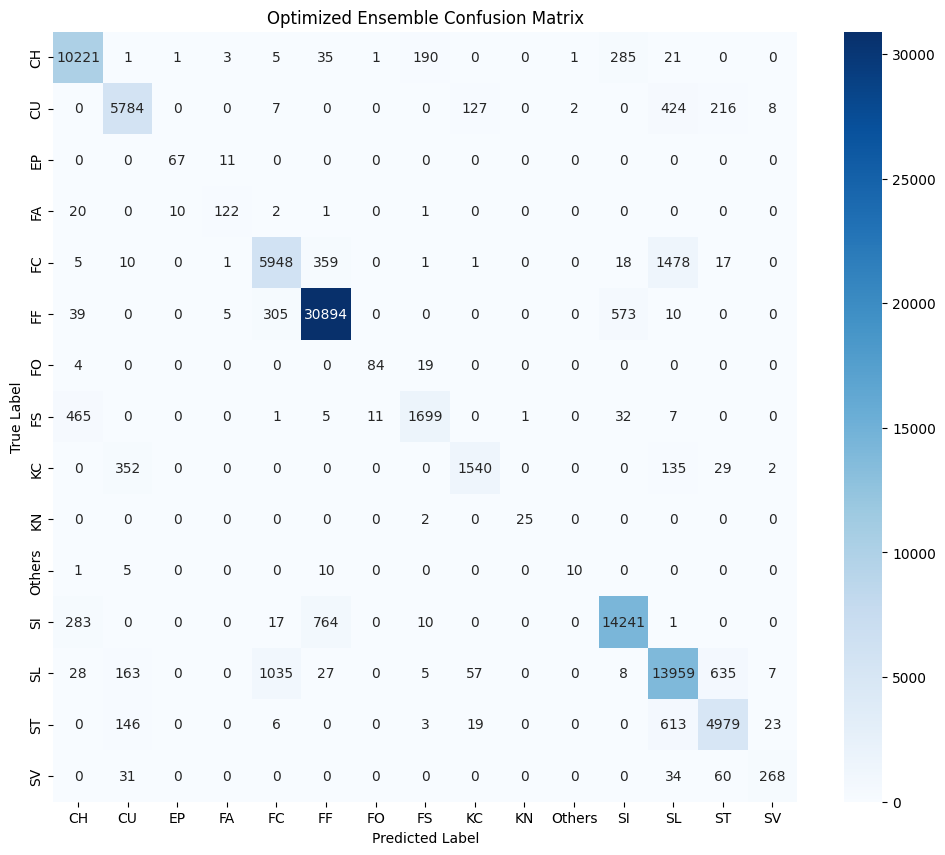

In [8]:
# === Detailed Evaluation ===
print(classification_report(y_valid, y_pred, target_names=le.classes_))

# FC Recall Check
fc_idx = le.transform(['FC'])[0]
fc_report = classification_report(y_valid, y_pred, output_dict=True, target_names=le.classes_)
print(f"\nFC Recall: {fc_report['FC']['recall']:.4f} (Baseline: 0.76)")

# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_valid, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Optimized Ensemble Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()
